
# SNARK : Modélisation Simple (R1CS vers QAP)
Dans ce notebook, nous explorons le processus de conversion d'une équation polynomiale en un système de contraintes R1CS (Rank 1 Constraint Systems) puis en un QAP (Quadratic Arithmetic Programs). 

L'exemple donné est celui où Bob souhaite prouver qu'il connaît un secret \( x \) tel que \( x^3+x+5 = 35 \). Nous allons décomposer cette équation, la modéliser sous forme de circuit arithmétique, puis la convertir en un système R1CS.


In [20]:
import zktool as zk
import numpy as np


## Entrée de l'équation
Veuillez entrer une équation polynomiale de type \( x^3 + x + 5 \). Nous allons ensuite la décomposer et la modéliser sous forme de circuit arithmétique.


In [21]:
eq_input=input("Enter the equation: de type x^3 + x + 5") #METTRE DES COEFFICIENTS >=0, aucune negatif pour l'instant


## Décomposition de l'équation et Modélisation des Circuits Arithmétiques
Une fois que nous avons l'équation, nous pouvons la décomposer en termes individuels et la représenter sous forme de circuit arithmétique. Le résultat ci-dessous montre cette représentation.


In [22]:
def transformer_equation(enonce):
    lignes = enonce.split('\n')
    lignes_nettoyees = [ligne.strip() for ligne in lignes if ligne.strip()]
    return lignes_nettoyees


equations = zk.decompose_polynomial(eq_input)

equation_mano=''''''

# Pour tester à la main il faut juste copier coller ses équations dans la variable equation_mano en dessus. 
# Sinon laisser un string vide comme au dessus.
equation_mano='''v1 = x * x
v2 = x * v1
v3 = 3 * v2
v4 = 5 * v1
v5 = 10 * x
out = v3 + v4 + v5 + 3'''


if equation_mano:
    equations=transformer_equation(equation_mano)

unique_words = zk.get_unique_words(equations)


print("Modelisation des circuits arithmetiques :")
for eq in equations:
    print(eq)

print("\nEnsemble des varibles =",unique_words)


Modelisation des circuits arithmetiques :
v1 = x * x
v2 = x * v1
v3 = 3 * v2
v4 = 5 * v1
v5 = 10 * x
out = v3 + v4 + v5 + 3

Ensemble des varibles = {'v5', 'v2', 'v3', 'v1', '1', 'out', 'v4', 'x'}



## Conversion du Circuit en R1CS
Le système R1CS (Rank 1 Constraint Systems) est une façon de représenter un ensemble de contraintes sous forme de matrices. Pour chaque équation du circuit, nous allons créer trois vecteurs associés (un pour chaque matrice A, B, C) qui représentent cette équation dans le système R1CS.


In [23]:
#création des 3 matrice vides A B C
L= []
R= []
O= []

print("Equations :")
for eq in equations:
    print(eq)
print(" ")

ref_array=list(unique_words)
print("Vecteur solution :")
print(ref_array)
print(' ')

print("Matrice L R O :")
for eq in equations:
    eq_split=eq.split()
    #print(eq_split)

    if eq_split[3]=='*':
        vecta=zk.get_position_vector(ref_array, eq_split[2])
        L.append(vecta)
        vectb=zk.get_position_vector(ref_array, eq_split[4])
        R.append(vectb)
        vectc=zk.get_position_vector(ref_array, eq_split[0])
        O.append(vectc)

    if eq_split[3]=='+':
        if "out" in eq:
            list_var = eq_split[2:]
        else:
            list_var = [eq_split[2],eq_split[4]]
        vecta=zk.get_position_vector(ref_array, list_var)
        L.append(vecta)
        vectb=zk.get_position_vector(ref_array, "1")
        R.append(vectb)
        vectc=zk.get_position_vector(ref_array, eq_split[0])
        O.append(vectc)
        
print("L=")
for ligne in L:
    print(ligne)
print(" ")

print("R=")
for ligne in R:
    print(ligne)
print(" ")

print("O=")
for ligne in O:
    print(ligne)
print(" ")

Equations :
v1 = x * x
v2 = x * v1
v3 = 3 * v2
v4 = 5 * v1
v5 = 10 * x
out = v3 + v4 + v5 + 3
 
Vecteur solution :
['v5', 'v2', 'v3', 'v1', '1', 'out', 'v4', 'x']
 
Matrice L R O :
L=
[0, 0, 0, 0, 0, 0, 0, 1]
[0, 0, 0, 0, 0, 0, 0, 1]
[0, 0, 0, 0, 3, 0, 0, 0]
[0, 0, 0, 0, 5, 0, 0, 0]
[0, 0, 0, 0, 10, 0, 0, 0]
[1, 0, 1, 0, 3, 0, 1, 0]
 
R=
[0, 0, 0, 0, 0, 0, 0, 1]
[0, 0, 0, 1, 0, 0, 0, 0]
[0, 1, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 1]
[0, 0, 0, 0, 1, 0, 0, 0]
 
O=
[0, 0, 0, 1, 0, 0, 0, 0]
[0, 1, 0, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 1, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 0, 0]
 


## Conversion R1CS en QAP

Graphiquement on peut aussi utiliser https://www.geogebra.org/calculator (ce qui est suffiant pour l'instant)
sinon un outils plus complexe : Maple


PolyL:

[[  0.008  -0.125   0.708  -1.875   2.283  -1.   ]
 [  0.      0.      0.      0.      0.      0.   ]
 [  0.008  -0.125   0.708  -1.875   2.283  -1.   ]
 [  0.      0.      0.      0.      0.      0.   ]
 [ -0.225   3.708 -23.125  67.792 -90.15   42.   ]
 [  0.      0.      0.      0.      0.      0.   ]
 [  0.008  -0.125   0.708  -1.875   2.283  -1.   ]
 [  0.033  -0.625   4.417 -14.375  20.55   -9.   ]]


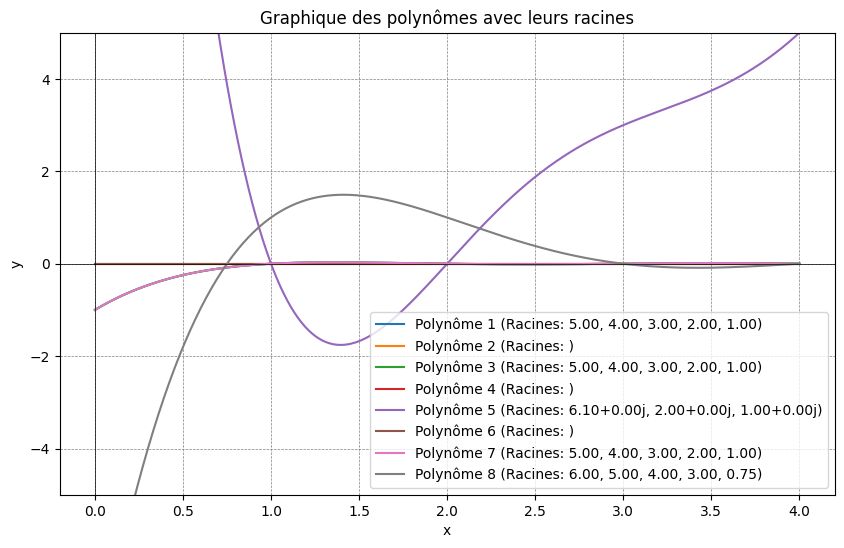


PolyR:

[[  0.      0.      0.      0.      0.      0.   ]
 [ -0.083   1.5   -10.083  31.    -42.333  20.   ]
 [  0.      0.      0.      0.      0.      0.   ]
 [  0.125  -2.208  14.625 -44.792  62.25  -30.   ]
 [  0.008  -0.125   0.708  -1.875   2.283  -1.   ]
 [  0.      0.      0.      0.      0.      0.   ]
 [  0.      0.      0.      0.      0.      0.   ]
 [ -0.05    0.833  -5.25   15.667 -22.2    12.   ]]


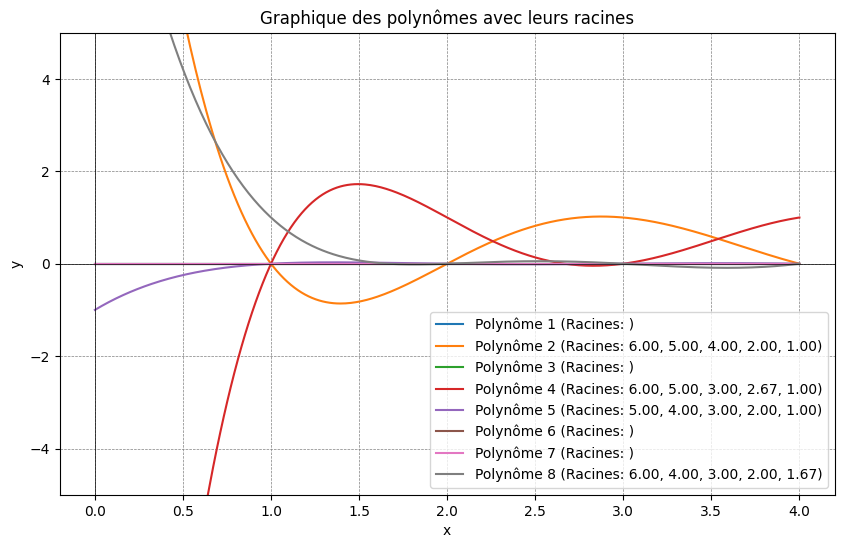


PolyO:

[[ -0.042   0.667  -3.958  10.833 -13.5     6.   ]
 [  0.042  -0.792   5.708 -19.208  29.25  -15.   ]
 [ -0.083   1.5   -10.083  31.    -42.333  20.   ]
 [ -0.008   0.167  -1.292   4.833  -8.7     6.   ]
 [  0.      0.      0.      0.      0.      0.   ]
 [  0.008  -0.125   0.708  -1.875   2.283  -1.   ]
 [  0.083  -1.417   8.917 -25.583  33.    -15.   ]
 [  0.      0.      0.      0.      0.      0.   ]]


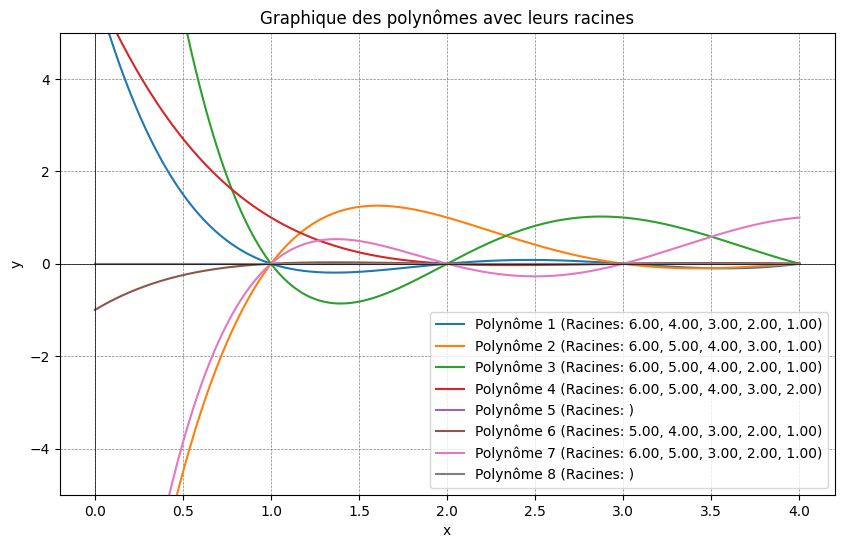

In [24]:
#Ici on cherche les coefficients des polynomes de chaque matrice

L=np.array(L)
R=np.array(R)
O=np.array(O)

# Convert matrices to their transpose for calculations
At, Bt, Ct = L.transpose(), R.transpose(), O.transpose()

# Calculate polynomial coefficient matrices
PolyL = zk.interpolate_and_get_coeff_matrix(At)
PolyR = zk.interpolate_and_get_coeff_matrix(Bt)
PolyO = zk.interpolate_and_get_coeff_matrix(Ct)


# Configuration de l'affichage
np.set_printoptions(precision=3, suppress=True)

def afficher_polynome(nom, poly):
    print(f"\n{nom}:\n")
    print(np.array(poly))


# Exemple d'utilisation
afficher_polynome("PolyL", PolyL)
zk.plot_polynomials(PolyL, [0, 4],[-5, 5]) #zk.plot_polynomials(PolyL, [xmin, xmax],[ymin, ])

afficher_polynome("PolyR", PolyR)
zk.plot_polynomials(PolyR, [0, 4],[-5, 5])

afficher_polynome("PolyO", PolyO)
zk.plot_polynomials(PolyO, [0, 4],[-5, 5])


## Calcul de la preuve

In [30]:
values = {"x": 3}

S = zk.compute_solution_vector(ref_array, equations, values)
print("\nSolution Vector:", S)
print("\nVecteur avec variable ",ref_array)

v1 = 9
v2 = 27
v3 = 81
v4 = 45
v5 = 30
out = 159

Solution Vector: [30, 27, 81, 9, 1, 159, 45, 3]

Vecteur avec variable  ['v5', 'v2', 'v3', 'v1', '1', 'out', 'v4', 'x']


-Imaginions si le prouver ne connait pas la solution, il va donner un x qui ne correspond pas à out. Ici x=3 donc la fonction zk.compute_solution_vector va forcement calculer la bonne sortie 35 => Solution Vector: [3, 1, 9, 35, 27, 30].

-Si on veut tester un prouver qui ne connait pas le solution on peux changer manuellement S = [3, 1, 9, **34**, 27, 30]. Maintenant il suffit d'aller voir la fin du programme pour voir si le verifier approuve ou non la preuve.

T = [ -43620.     192459.4   -362183.413  383193.072 -253084.55   109399.558
  -31461.848    5966.567    -716.7        49.403      -1.488]
racine de T = [1.   +0.j    0.989+0.j    0.551+0.j    0.5  +0.j    0.333+0.j
 0.25 +0.j    0.211+0.022j 0.211-0.022j 0.2  +0.j    0.167+0.j   ]


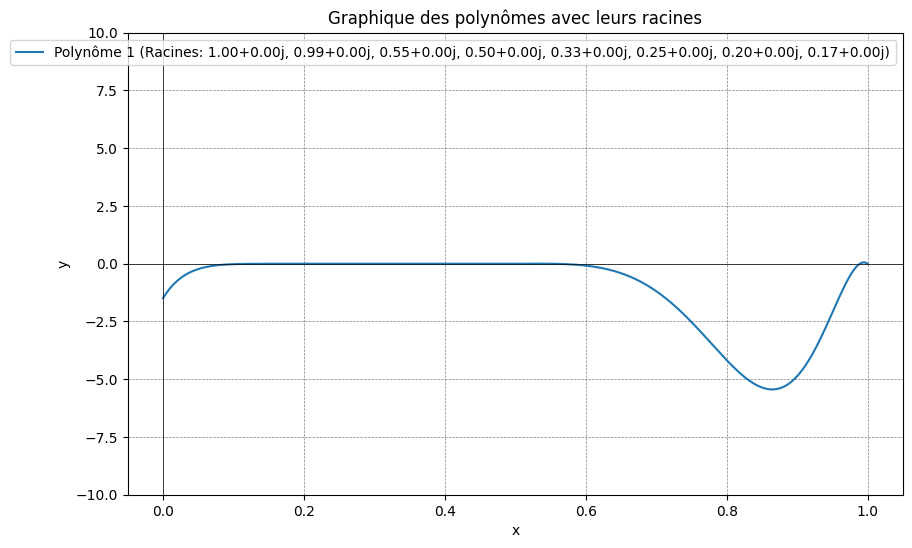

A.S = [-141.     327.7   -267.833  100.625  -17.667    1.175]
racine de AS = [1.095+0.j    0.4  +0.06j  0.4  -0.06j  0.215+0.019j 0.215-0.019j]


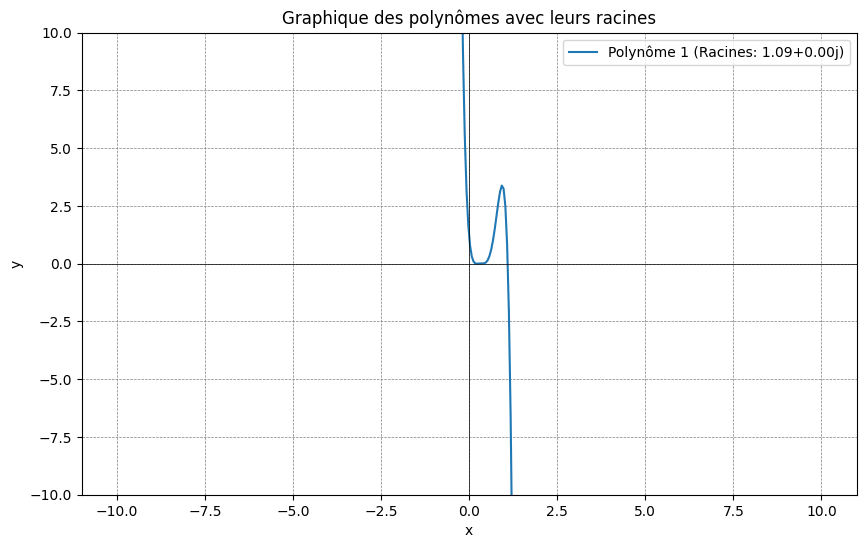

B.S = [ 305.    -647.067  479.    -155.667   23.      -1.267]
racine de BS = [0.955+0.j    0.574+0.j    0.213+0.012j 0.213-0.012j 0.166+0.j   ]


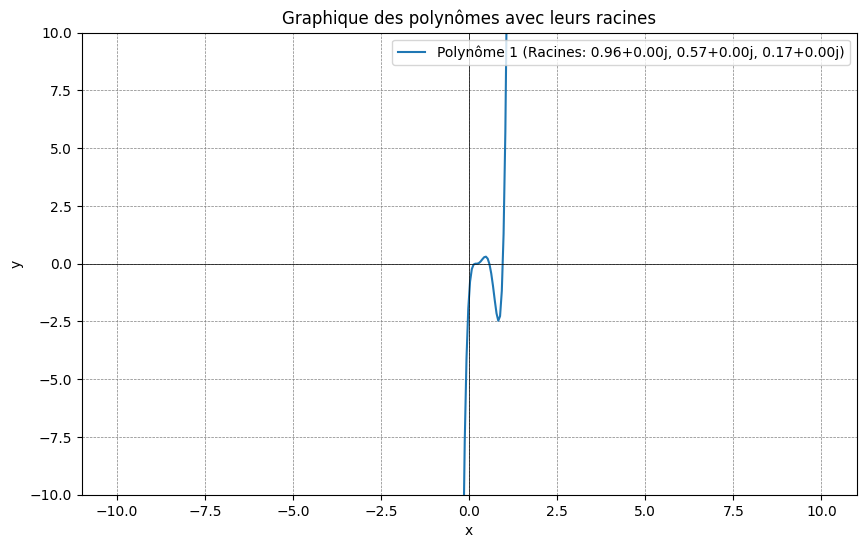

C.S = [  615.    -1274.5     911.5    -279.125    38.       -1.875]
racine de CS = [0.934+0.j    0.598+0.j    0.208+0.025j 0.208-0.025j 0.124+0.j   ]


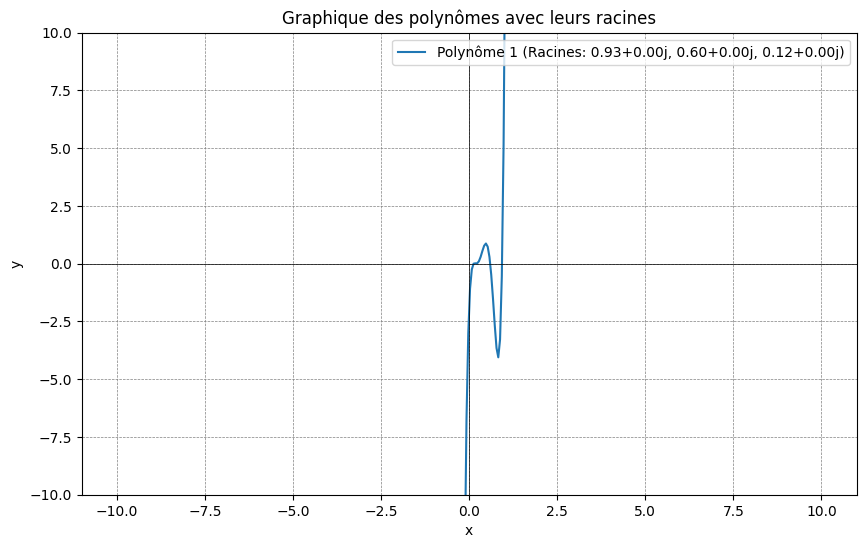

In [26]:
#Ici on chercher trouver le polynome T qui repond à tous les polynomes de la matrice A;B;C
result_LS = zk.polynomial_dot_product(PolyL, S)
result_RS = zk.polynomial_dot_product(PolyR, S)
result_OS = zk.polynomial_dot_product(PolyO, S)

# print("A.S =", result_AS)
# print("B.S =", result_BS)
# print("C.S =", result_CS)

# Calcul de la convolution
convolution_product = np.convolve(result_LS, result_RS)

# Calcul de T
T = convolution_product - np.concatenate((result_OS, np.zeros(len(convolution_product) - len(result_OS))))

print("T =", T)

print("racine de T =", np.roots(T))
zk.plot_polynomials([T],[0,1])

print("A.S =", result_LS)
print("racine de AS =", np.roots(result_LS))
zk.plot_polynomials([result_LS])

print("B.S =", result_RS)
print("racine de BS =", np.roots(result_RS))
zk.plot_polynomials([result_RS])

print("C.S =", result_OS)
print("racine de CS =", np.roots(result_OS))
zk.plot_polynomials([result_OS])



In [27]:
# Z est le diviseur de T pour verifier s'il y a un reste ou non
print(len(equations))
Z = zk.polynomial_coefficients(len(equations))
print("Z =", Z)
print("T = ", T)

6
Z = [  720 -1764  1624  -735   175   -21     1]
T =  [ -43620.     192459.4   -362183.413  383193.072 -253084.55   109399.558
  -31461.848    5966.567    -716.7        49.403      -1.488]


In [28]:
quotient,remainder=zk.polynomial_division(T, Z)

# Imprimer le quotient
print(f"h = T / Z = {quotient}")
print(f"R = T % Z = {remainder}")
sum=0
for i in remainder:
    sum+=i
print("Somme des coefficients du reste =",sum)

# Vérifiez si le reste est nul
if not zk.is_remainder_close_to_zero(remainder, 1e-5):
    print("La preuve est refutée !")
else:
    print("La preuve est bonne")

h = T / Z = [-60.583 118.876 -75.138  18.148  -1.488]
R = T % Z = [-0.]
Somme des coefficients du reste = -4.241051954068098e-14
La preuve est bonne
